In [1]:
from Dataset_Loader import load_leafs_dataset
from Training import train_cnn
from Model_Evaluation import evaluate_model_with_outputs

from torch import nn, optim, manual_seed, flatten
from Util import apply_conv, apply_pool
import matplotlib.pyplot as plt
from time import time

In [2]:
batch_size = 20
test_split_size = 0.2

images_train, images_test, labels_train, labels_test = load_leafs_dataset(
    test_split_size,
    batch_size 
)

Reading CSV: 0.029 seconds
Encoding Labels: 0.001 seconds
Resizing Images: 2.817 seconds
Splitting Data: 0.349 seconds
Converting To Tensor: 1.135 seconds
Dividing To Batches: 0.001 seconds


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        width = 1633
        height = 1089
        self.pool1, width, height = apply_pool(width, height, kernel_size=2, stride=2)
        self.pool2, width, height = apply_pool(width, height, kernel_size=2, stride=2)
        self.pool3, width, height = apply_pool(width, height, kernel_size=2, stride=2)
    
        self.conv1, width, height = apply_conv(width, height, 1, 6, kernel_size=3, stride=1, padding=1)
        self.pool4, width, height = apply_pool(width, height, kernel_size=2, stride=2)

        self.conv2, width, height = apply_conv(width, height, 6, 16, kernel_size=3, stride=1, padding=1)
        self.pool5, width, height = apply_pool(width, height, kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16*width*height, 1000)
        self.fc2 = nn.Linear(1000, 99)

    def forward(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool3(x)

        x = nn.functional.relu(self.conv1(x))
        x = self.pool4(x)

        x = nn.functional.relu(self.conv2(x))
        x = self.pool5(x)

        x = flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x), dim=1)
        return x

# Optimizer Analysis

Analysing SGD Optimizer...
Epoch: 0 / loss: 2.482940673828125
Epoch: 1 / loss: 0.3153478801250458
Epoch: 2 / loss: 0.07088630646467209
Epoch: 3 / loss: 0.024779869243502617
Epoch: 4 / loss: 0.012468360364437103
Epoch: 5 / loss: 0.008250379003584385
Epoch: 6 / loss: 0.006310236174613237
Epoch: 7 / loss: 0.00515884580090642
Epoch: 8 / loss: 0.004452220629900694
Epoch: 9 / loss: 0.003916298970580101
Finished in 127.209 seconds
Analysing Adagrad Optimizer...
Epoch: 0 / loss: 8.778667449951172
Epoch: 1 / loss: 1.210239291191101
Epoch: 2 / loss: 0.051966890692710876
Epoch: 3 / loss: 0.029079265892505646
Epoch: 4 / loss: 0.01051346119493246
Epoch: 5 / loss: 0.007813828065991402
Epoch: 6 / loss: 0.005932461470365524
Epoch: 7 / loss: 0.004948908928781748
Epoch: 8 / loss: 0.004296696279197931
Epoch: 9 / loss: 0.0038350720424205065
Finished in 153.35 seconds
Analysing RMSprop Optimizer...
Epoch: 0 / loss: 3.211134672164917
Epoch: 1 / loss: 0.1456332504749298
Epoch: 2 / loss: 0.004624092951416969


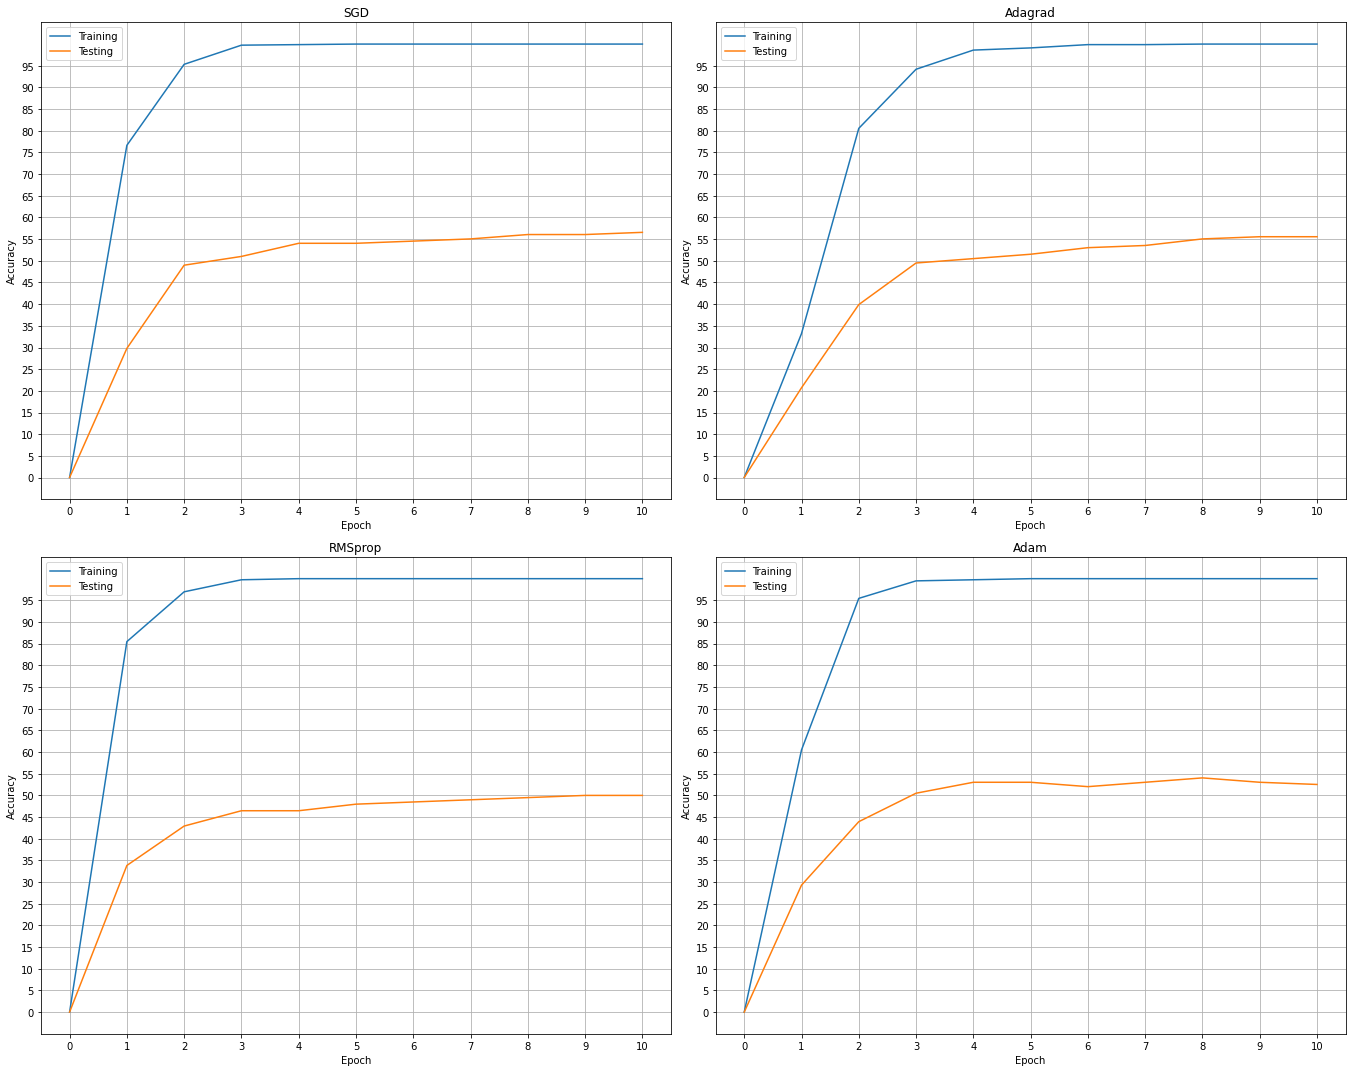

In [4]:
optimizers = [
    optim.SGD, optim.Adagrad, optim.RMSprop, optim.Adam
]
optimizer_names = [
    'SGD', 'Adagrad', 'RMSprop', 'Adam'
]
fig = plt.figure(figsize=(19, 15))

for i in range(len(optimizers)):
    print(f'Analysing {optimizer_names[i]} Optimizer...')
    manual_seed(1)
    model = CNN()
    optimizer = optimizers[i](model.parameters(), 0.001)
    epochs = 10
    initial_train_accuracy = evaluate_model_with_outputs(model, images_train, labels_train, batch_size, 0)
    initial_test_accuracy = evaluate_model_with_outputs(model, images_test, labels_test, batch_size, 1)

    time1 = time()
    trained_model, losses_train, accuracies_train, accuracies_test = train_cnn(
        model=model,
        images_train=images_train,
        labels_train=labels_train,
        images_test=images_test,
        labels_test=labels_test,
        epochs=epochs,
        batch_size=batch_size,
        lossFunction=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        print_loss=True,
        calc_accuracy=True
    )
    time2 = time()
    print(f'Finished in {round(time2 - time1, 3)} seconds')

    accuracies_train.insert(0, initial_train_accuracy)
    accuracies_test.insert(0, initial_test_accuracy)

    rng_x = range(epochs+1)
    rng_y = range(0, 100, 5)

    ax = fig.add_subplot(221 + i)
    ax.set_title(optimizer_names[i])
    plt.tight_layout()
    plt.plot(rng_x, accuracies_train, label='Training')
    plt.plot(rng_x, accuracies_test, label='Testing')
    plt.xlabel('Epoch')
    plt.xticks(rng_x, rng_x)
    plt.ylabel('Accuracy')
    plt.yticks(rng_y, rng_y)
    plt.grid()
    plt.legend()
plt.savefig("img1.jpg")
plt.show()

# L2 Regularization Coefficient Analysis

Analysing L2 Regularization Coefficient 0.001...
Epoch: 0 / loss: 2.6268436908721924
Epoch: 1 / loss: 0.2073323279619217
Epoch: 2 / loss: 0.020125694572925568
Epoch: 3 / loss: 0.0035147552844136953
Epoch: 4 / loss: 0.0019512688741087914
Epoch: 5 / loss: 0.0026445232797414064
Epoch: 6 / loss: 0.0017654473194852471
Epoch: 7 / loss: 0.0014964787987992167
Epoch: 8 / loss: 0.0013011778937652707
Epoch: 9 / loss: 0.0011923175770789385
Finished in 178.58 seconds
Analysing L2 Regularization Coefficient 0.01...
Epoch: 0 / loss: 1.932511329650879
Epoch: 1 / loss: 0.28464335203170776
Epoch: 2 / loss: 0.021143609657883644
Epoch: 3 / loss: 0.009049486368894577
Epoch: 4 / loss: 0.007628930266946554
Epoch: 5 / loss: 0.007694920990616083
Epoch: 6 / loss: 0.006792773958295584
Epoch: 7 / loss: 0.006309533957391977
Epoch: 8 / loss: 0.005794951692223549
Epoch: 9 / loss: 0.0053769187070429325
Finished in 184.564 seconds
Analysing L2 Regularization Coefficient 0.1...
Epoch: 0 / loss: 3.595324754714966
Epoch:

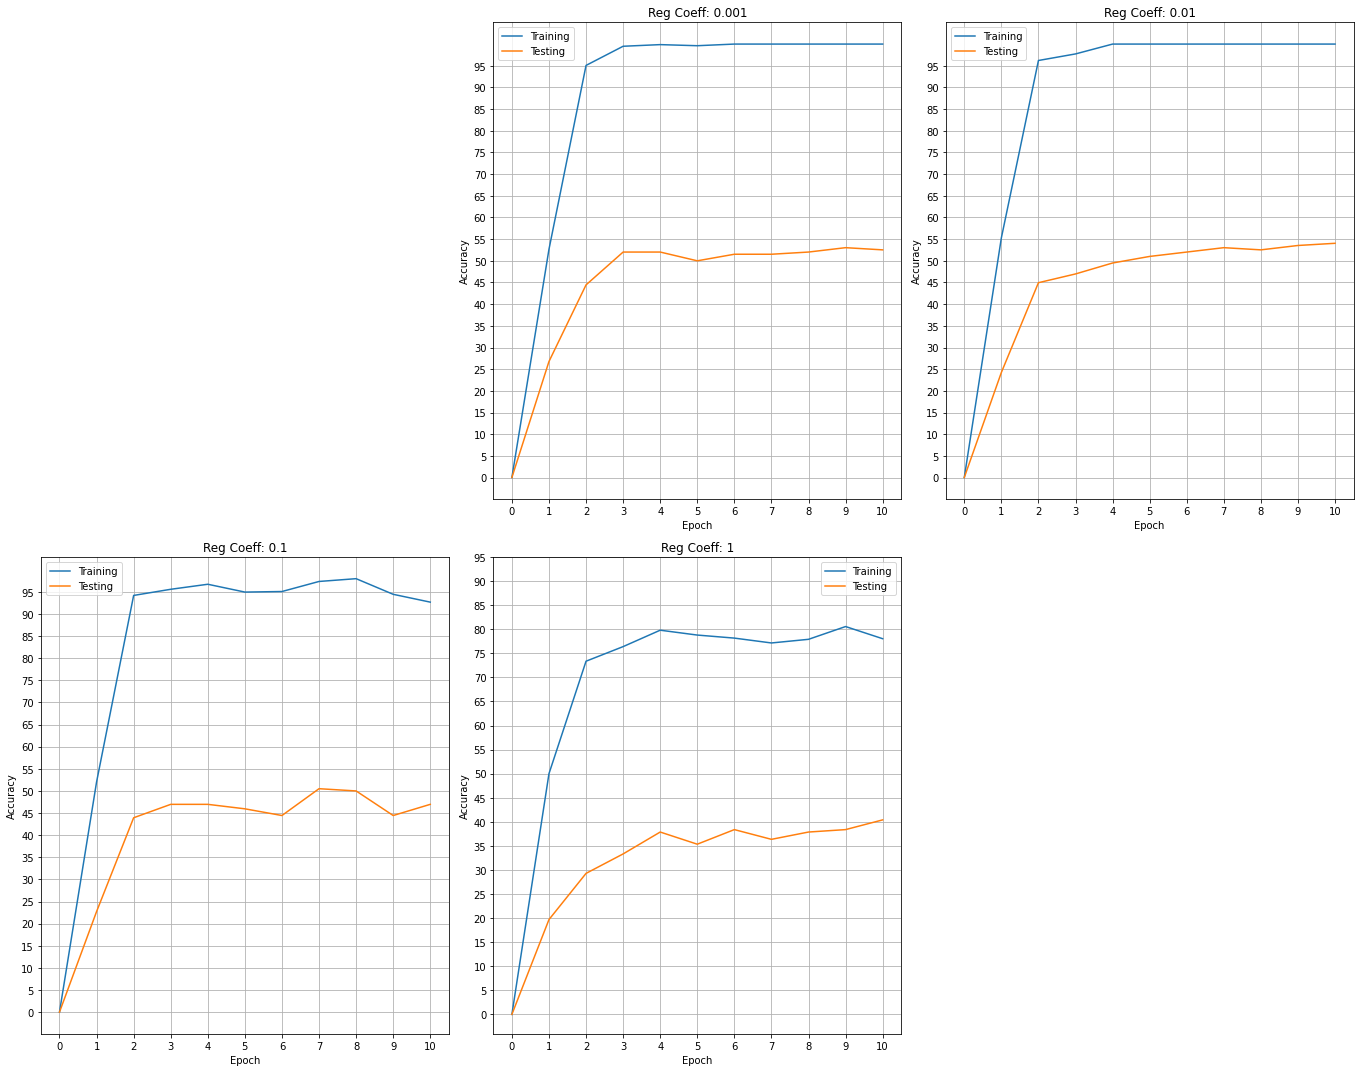

In [4]:
reg_coeffs = [
    0, 0.001, 0.01, 0.1, 1
]
fig = plt.figure(figsize=(19, 15))

for i in range(1, len(reg_coeffs)):
    print(f'Analysing L2 Regularization Coefficient {reg_coeffs[i]}...')
    manual_seed(1)
    model = CNN()
    epochs = 10
    initial_train_accuracy = evaluate_model_with_outputs(model, images_train, labels_train, batch_size, 0)
    initial_test_accuracy = evaluate_model_with_outputs(model, images_test, labels_test, batch_size, 1)

    time1 = time()
    trained_model, losses_train, accuracies_train, accuracies_test = train_cnn(
        model=model,
        images_train=images_train,
        labels_train=labels_train,
        images_test=images_test,
        labels_test=labels_test,
        epochs=epochs,
        batch_size=batch_size,
        lossFunction=nn.CrossEntropyLoss(),
        optimizer=optim.Adam(model.parameters(), 0.001, weight_decay=reg_coeffs[i]),
        print_loss=True,
        calc_accuracy=True
    )
    time2 = time()
    print(f'Finished in {round(time2 - time1, 3)} seconds')

    accuracies_train.insert(0, initial_train_accuracy)
    accuracies_test.insert(0, initial_test_accuracy)

    rng_x = range(epochs+1)
    rng_y = range(0, 100, 5)

    ax = fig.add_subplot(231 + i)
    ax.set_title(f'Reg Coeff: {reg_coeffs[i]}')
    plt.tight_layout()
    plt.plot(rng_x, accuracies_train, label='Training')
    plt.plot(rng_x, accuracies_test, label='Testing')
    plt.xlabel('Epoch')
    plt.xticks(rng_x, rng_x)
    plt.ylabel('Accuracy')
    plt.yticks(rng_y, rng_y)
    plt.grid()
    plt.legend()    
plt.savefig("img2.jpg")
plt.show()